In [2]:
#!pip install causalml
#!pip install catboost


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import joblib
import matplotlib.pyplot as plt
from causalml.inference.meta import LRSRegressor, XGBTRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.propensity import ElasticNetPropensityModel
import warnings
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from causalml.metrics import get_cumgain, plot_gain
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from lightgbm import LGBMRegressor
from causalml.inference.tf import DragonNet
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
from causalml.metrics import get_cumgain, plot_gain



warnings.filterwarnings("ignore")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Load the dataset
data = pd.read_csv("/content/TravelInsurancePrediction.csv")

# Display basic information
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB
None
        Unnamed: 0          Age  AnnualIncome  FamilyMembers  ChronicDiseases  \
count  1987.000000  1987.000000  1.987000e+03    1987.000000      1987.000000   
mean    993.000000    29.650226  9.327630e+05       4.752894         0.277806   
std  

In [5]:
# Drop the column containing row number
data = data.drop('Unnamed: 0', axis=1)
# Display the first few rows
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


#### **Data Exploration**


In [6]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64


Text(0.5, 1.0, 'Target Variable Distribution (Travel Insurance)')

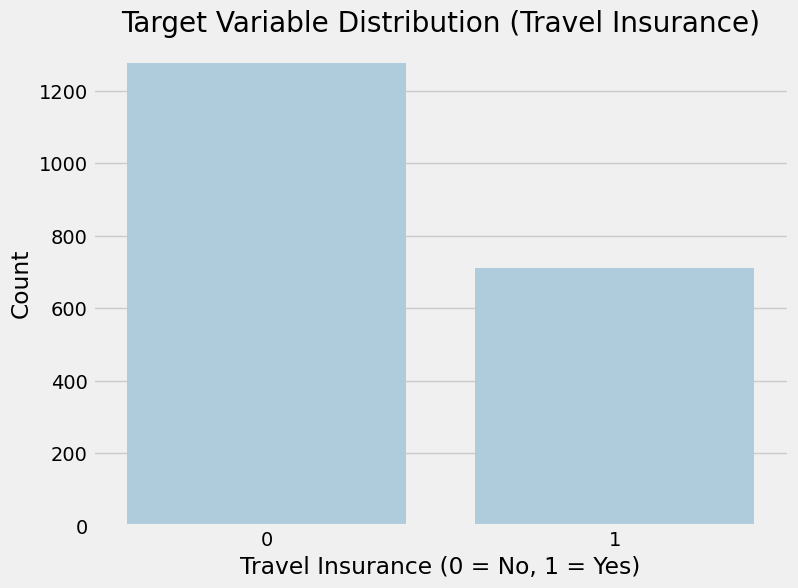

In [7]:
# Create the plot with improved formatting
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=data, x='TravelInsurance')
# Add labels
plt.xlabel('Travel Insurance (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Target Variable Distribution (Travel Insurance)')


In [8]:
# Check for class imbalance
class_counts = data['TravelInsurance'].value_counts(normalize=True)
print("\nClass Distribution (Proportion):")
print(class_counts)


Class Distribution (Proportion):
TravelInsurance
0    0.642677
1    0.357323
Name: proportion, dtype: float64


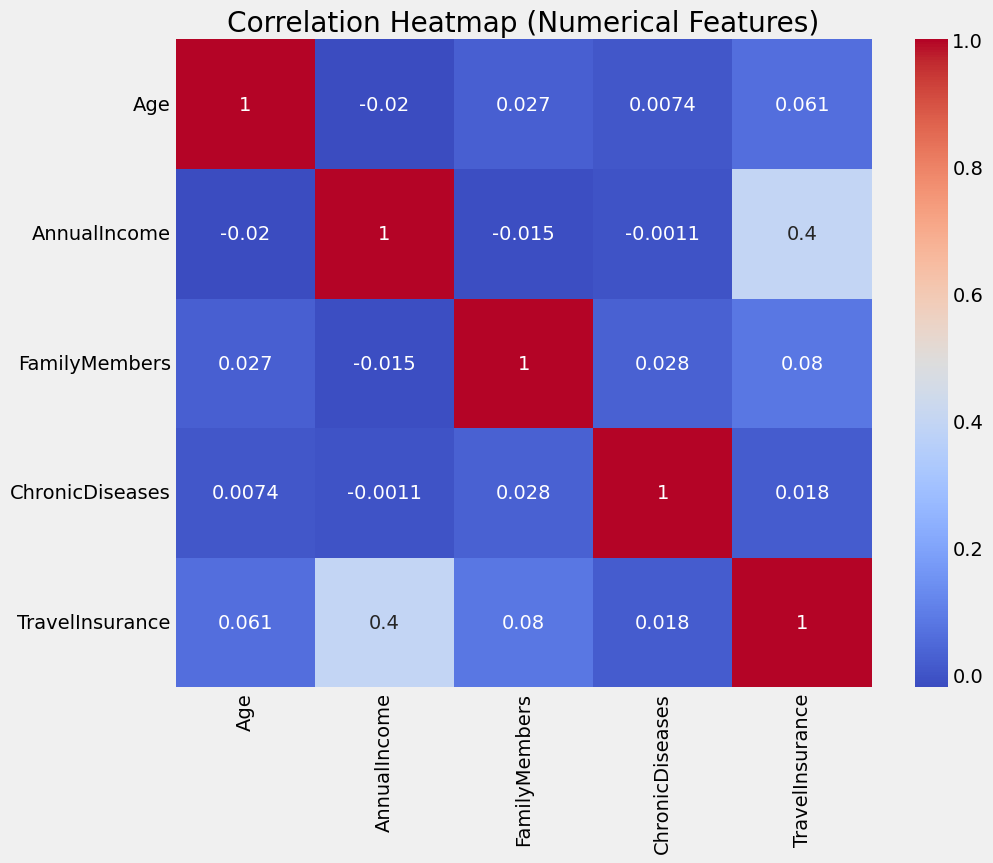

In [9]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Check if there are any numerical columns
if not numerical_data.empty:
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap (Numerical Features)')
    plt.show()
else:
    print("No numerical columns found for correlation heatmap.")

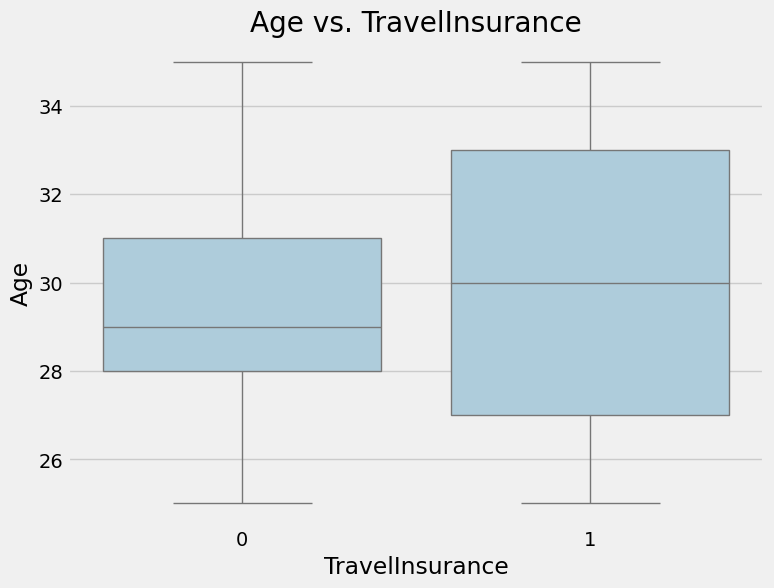

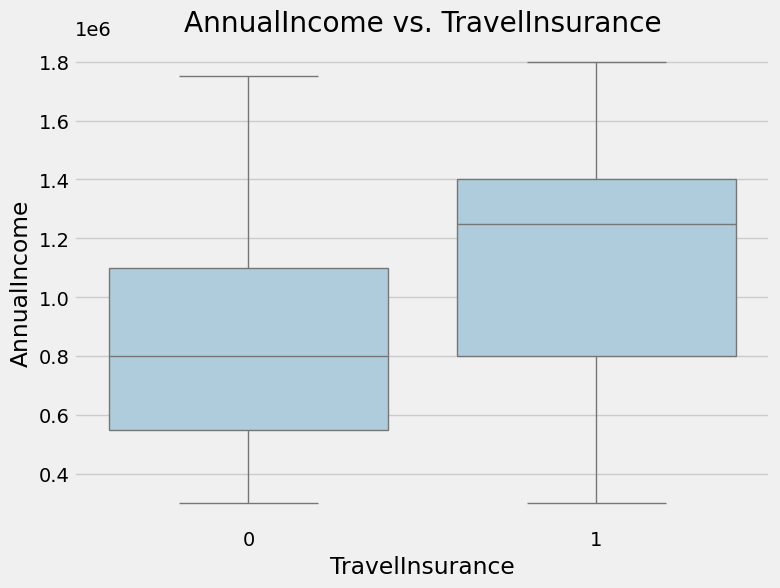

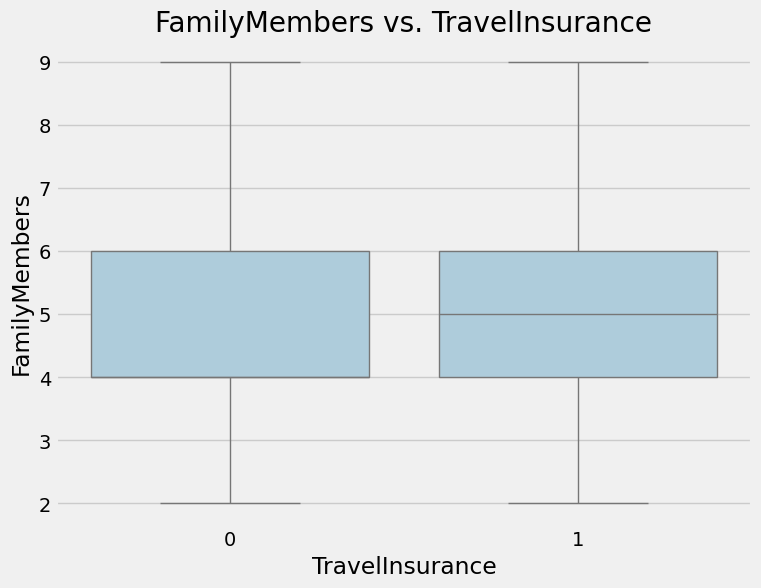

In [10]:
# Boxplot for numerical features
numerical_features = []
for column in data.select_dtypes(include=[np.number]).columns:
    if len(data[column].unique()) > 2 and column != 'TravelInsurance':  # More than 2 unique values
        numerical_features.append(column)

# Create boxplots only for continuous numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data['TravelInsurance'], y=data[feature])
    plt.title(f'{feature} vs. TravelInsurance')
    plt.show()

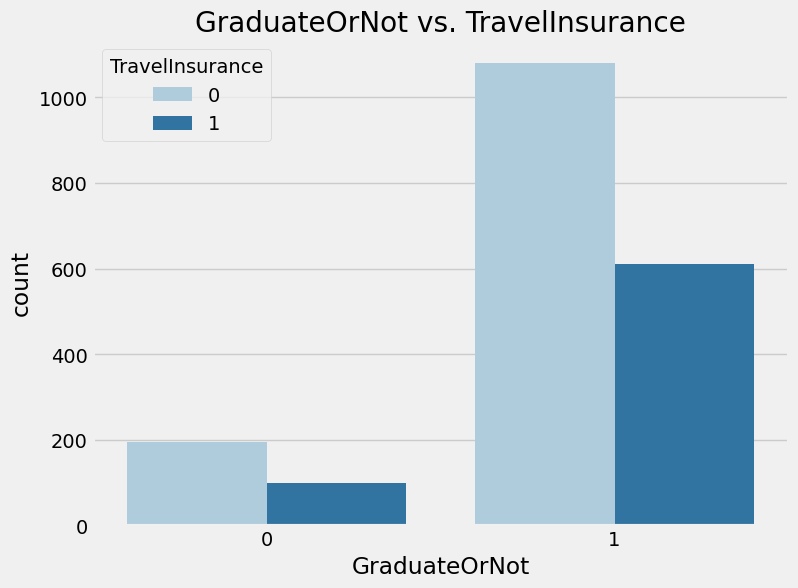

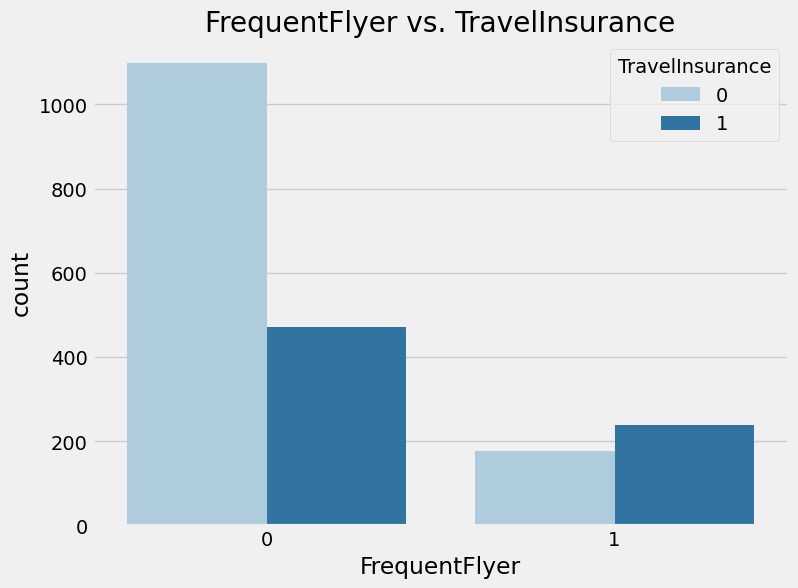

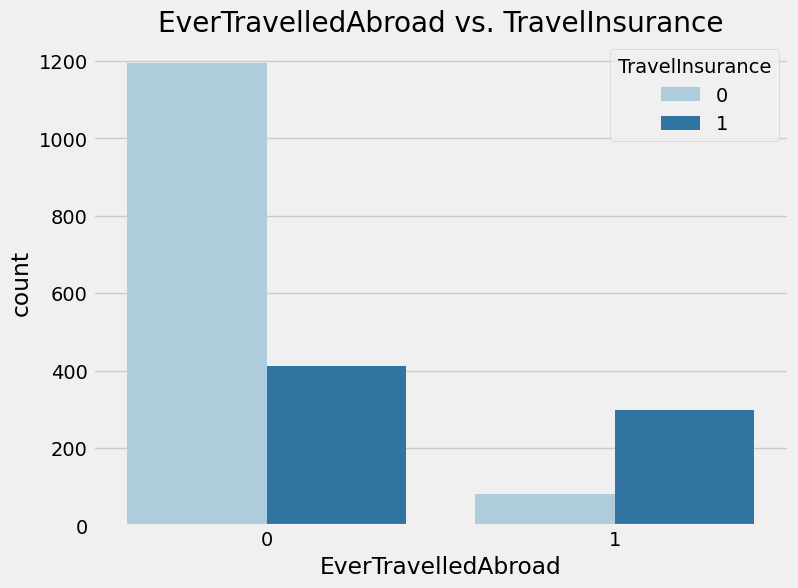

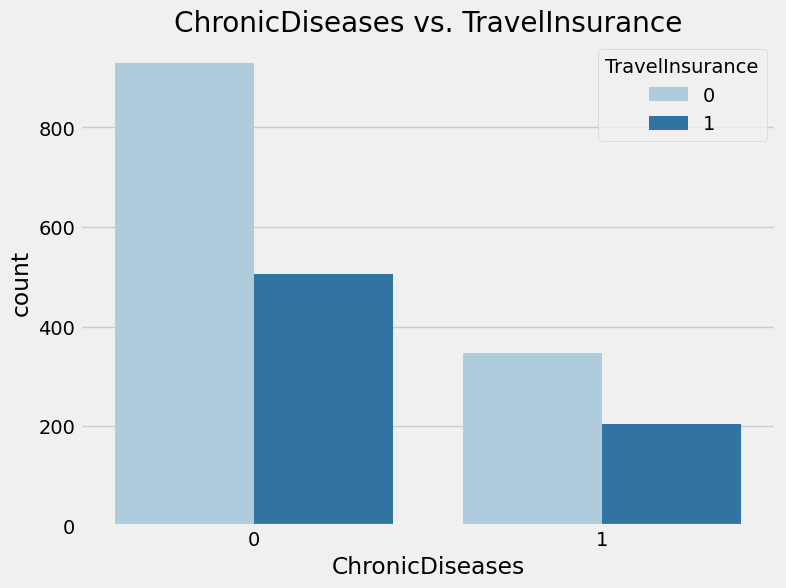

In [11]:
# For binary variables
binary_features = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']
for feature in binary_features:
    data[feature] = data[feature].map({'Yes': 1, 'No': 0})

# For binary features, use countplots
for feature in binary_features + ['ChronicDiseases']:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature, hue='TravelInsurance')
    plt.title(f'{feature} vs. TravelInsurance')
    plt.show()

#### Data preprocessing

In [12]:
# Generate a class with multiple feature engineered variables
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_stats_ = None
        self.income_mean_ = None

    def fit(self, X, y=None):
        # Store any parameters needed from training data
        self.age_stats_ = X.groupby('Employment Type')['Age'].agg(['mean', 'std'])
        self.income_mean_ = X['AnnualIncome'].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Add Log_Income (was missing)
        X_copy['Log_Income'] = np.log1p(X_copy['AnnualIncome'])

        # Age-based Features
        X_copy['AgeGroup'] = pd.cut(X_copy['Age'],
                                  bins=[0, 25, 35, 45, 55, 100],
                                  labels=['Young', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'])

        X_copy['Age_vs_Employment_Mean'] = X_copy.apply(
            lambda x: x['Age'] - self.age_stats_.loc[x['Employment Type'], 'mean'], axis=1)

        # Income-based Features
        X_copy['Income_per_Family_Member'] = X_copy['AnnualIncome'] / X_copy['FamilyMembers']
        X_copy['Income_Bracket'] = pd.qcut(X_copy['AnnualIncome'],
                                         q=5,
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

        X_copy['Income_vs_Mean'] = X_copy['AnnualIncome'] - self.income_mean_

        # Risk Score Features
        X_copy['Risk_Score'] = (X_copy['Age'] * 0.3 +
                              X_copy['ChronicDiseases'] * 2 +
                              (X_copy['FamilyMembers'] > 3).astype(int) * 0.5)

        X_copy['Travel_Risk'] = ((X_copy['FrequentFlyer'] == 1).astype(int) +
                               (X_copy['EverTravelledAbroad'] == 1).astype(int) +
                               X_copy['ChronicDiseases'])

        # Interaction Features
        X_copy['Graduate_Traveller'] = X_copy['GraduateOrNot'] * X_copy['EverTravelledAbroad']
        X_copy['Health_Travel_Risk'] = X_copy['ChronicDiseases'] * X_copy['FrequentFlyer']
        X_copy['Income_Education'] = X_copy['AnnualIncome'] * X_copy['GraduateOrNot']

        # Family-based Features
        X_copy['Family_Size_Category'] = pd.cut(X_copy['FamilyMembers'],
                                              bins=[0, 2, 4, 6, float('inf')],
                                              labels=['Small', 'Medium', 'Large', 'Very Large'])

        X_copy['Income_per_Family_Category'] = pd.qcut(X_copy['Income_per_Family_Member'],
                                                     q=4,
                                                     labels=['Low', 'Medium', 'High', 'Very High'])

        return X_copy



In [13]:
# Prepare the data function
def prepare_data(data):
    # Separate features and target
    X = data.drop("TravelInsurance", axis=1)
    y = data["TravelInsurance"]

    # Convert binary variables if needed
    binary_features = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']
    for feature in binary_features:
        X[feature] = X[feature].map({'Yes': 1, 'No': 0})

    return X, y

In [14]:
# Integrate XGboost in the pipeline
class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, min_child_weight=1, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.random_state = random_state

    def fit(self, X, y):
        self.model = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            min_child_weight=self.min_child_weight,
            random_state=self.random_state,
            objective='binary:logistic',
            eval_metric='logloss'
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [15]:
# Define the preprocessing steps
def create_preprocessor():
    # Identify categorical and numerical columns
    categorical_cols = ['AgeGroup', 'Income_Bracket', 'Family_Size_Category',
                       'Income_per_Family_Category', 'Employment Type']
    numerical_cols = ['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases',
                     'Income_per_Family_Member', 'Log_Income', 'Risk_Score',
                     'Travel_Risk', 'Graduate_Traveller', 'Health_Travel_Risk',
                     'Income_Education', 'Age_vs_Employment_Mean', 'Income_vs_Mean']

    # Create preprocessing pipelines
    num_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Combine preprocessors
    preprocessor = ColumnTransformer([
        ("num", num_pipeline, numerical_cols),
        ("cat", cat_pipeline, categorical_cols)
    ])

    return preprocessor

In [16]:
# Separate features and target since we do not have any missing data we can define the pipeline before spliting
# however if therewere any missing one we would need to do this before to avoid data leakage
X = data.drop("TravelInsurance", axis=1)
y = data["TravelInsurance"]

# Use stratified sampling to handle imbalanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify categorical and numerical columns
categorical_cols = ['AgeGroup', 'Income_Bracket', 'Family_Size_Category',
                   'Income_per_Family_Category', 'Employment Type']
numerical_cols = ['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases',
                 'Income_per_Family_Member', 'Log_Income', 'Risk_Score',
                 'Travel_Risk', 'Graduate_Traveller', 'Health_Travel_Risk',
                 'Income_Education', 'Age_vs_Employment_Mean', 'Income_vs_Mean']


# Imputation strategies
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Scaling and encoding
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore")


#### Model Building and training

In [17]:
# Load and prepare data
X, y = prepare_data(data)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create preprocessor
preprocessor = create_preprocessor()

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Evaluate models
for model_name, model in models.items():
    pipeline = Pipeline([
        ("feature_engineer", FeatureEngineer()),
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    scores = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="roc_auc"
    )
    print(f"{model_name} - Mean ROC-AUC: {np.mean(scores):.3f}")


Logistic Regression - Mean ROC-AUC: 0.785
Random Forest - Mean ROC-AUC: 0.797


#### Hyperparameter tunning

In [18]:
def tune_model(X_train, y_train, preprocessor, model_type='rf'):
    base_pipeline = [
        ("feature_engineer", FeatureEngineer()),
        ("preprocessor", preprocessor)
    ]

    # Define different models and their parameter grids
    model_configs = {
        'rf': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__max_depth": [None, 10, 20],
                "classifier__min_samples_split": [2, 5, 10]
            }
        },
        'lr': {
            'model': LogisticRegression(random_state=42),
            'params': {
                "classifier__C": [0.001, 0.01, 0.1, 1, 10],
                "classifier__penalty": ['l2'],
                 "classifier__solver": ['lbfgs']
            }
        },
        'xgb': {
            'model': XGBoostWrapper(),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__max_depth": [3, 5, 7],
                "classifier__learning_rate": [0.01, 0.1, 0.3],
                "classifier__min_child_weight": [1, 3, 5]
            },
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__max_depth": [3, 5, 7],
                "classifier__learning_rate": [0.01, 0.1, 0.3],
                "classifier__min_child_weight": [1, 3, 5]
            }
        }
    }

    if model_type not in model_configs:
        raise ValueError(f"Model type {model_type} not supported. Choose from: {list(model_configs.keys())}")

    # Create the full pipeline with the selected model
    model_pipeline = Pipeline(base_pipeline + [
        ("classifier", model_configs[model_type]['model'])
    ])

    # Perform grid search
    grid_search = GridSearchCV(
        model_pipeline,
        model_configs[model_type]['params'],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Print results
    print(f"\nBest Parameters for {model_type.upper()}:")
    print(grid_search.best_params_)
    print(f"Best ROC-AUC Score: {grid_search.best_score_:.3f}")

    return grid_search



In [19]:
def evaluate_model(best_model, X_test, y_test):
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


Tuning RF...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters for RF:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best ROC-AUC Score: 0.812

Evaluating RF...

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       256
           1       0.88      0.56      0.69       142

    accuracy                           0.82       398
   macro avg       0.84      0.76      0.78       398
weighted avg       0.83      0.82      0.80       398



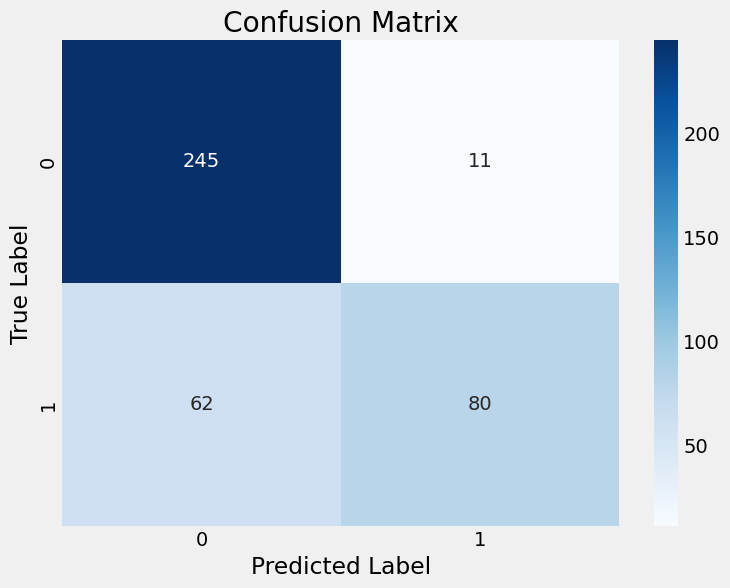

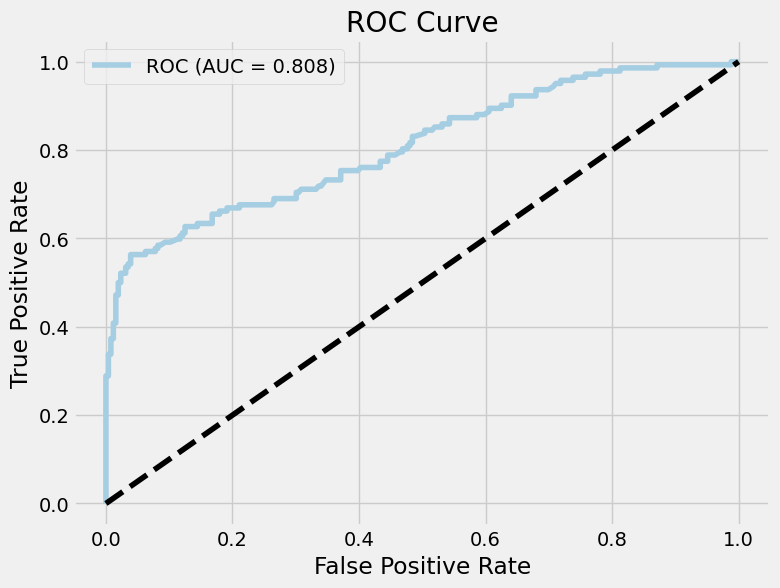


Tuning LR...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Parameters for LR:
{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best ROC-AUC Score: 0.785

Evaluating LR...

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       256
           1       0.83      0.49      0.62       142

    accuracy                           0.78       398
   macro avg       0.80      0.72      0.73       398
weighted avg       0.79      0.78      0.77       398



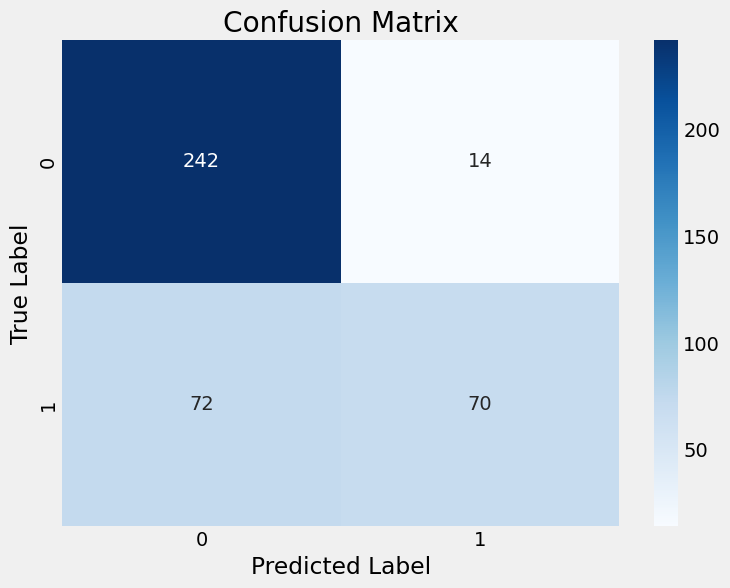

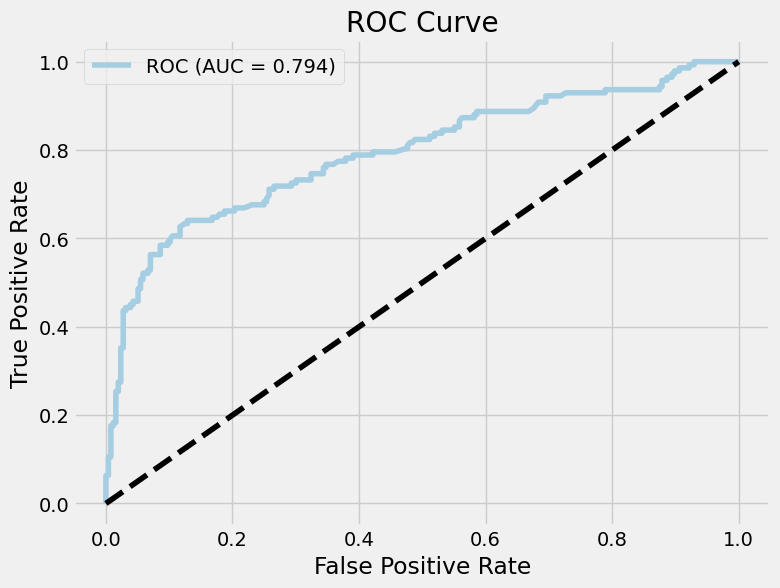


Tuning XGB...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters for XGB:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 50}
Best ROC-AUC Score: nan

Evaluating XGB...

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       256
           1       0.90      0.55      0.68       142

    accuracy                           0.82       398
   macro avg       0.85      0.76      0.78       398
weighted avg       0.83      0.82      0.80       398



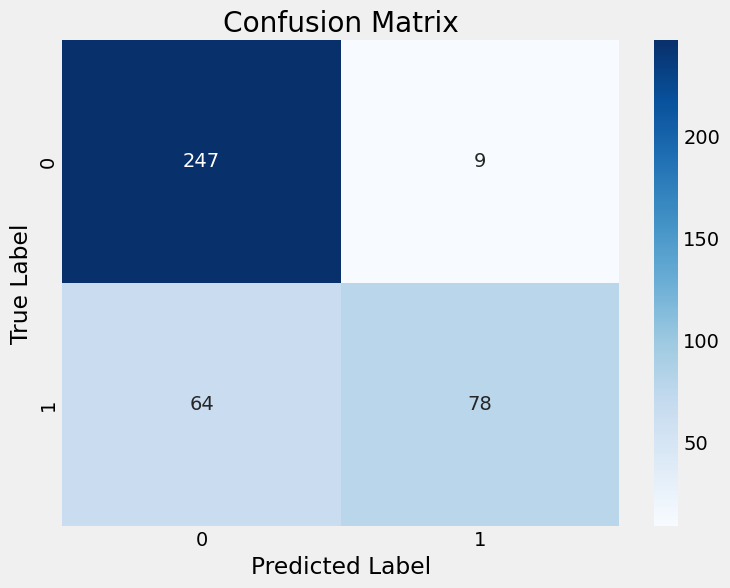

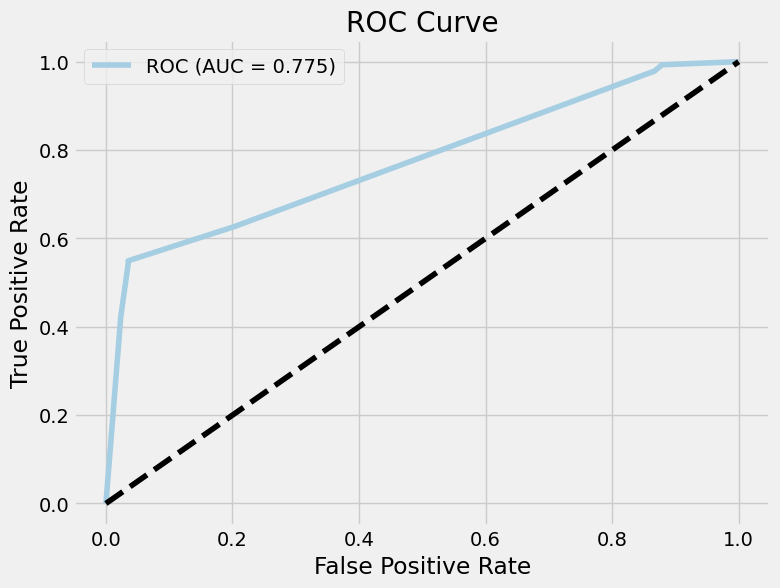


Model Comparison:

RF:
ROC-AUC Score: 0.808

LR:
ROC-AUC Score: 0.794

XGB:
ROC-AUC Score: 0.775


In [20]:
    # Load and prepare data
    X, y = prepare_data(data)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Create preprocessor
    preprocessor = create_preprocessor()

    # List of models to tune
    models_to_tune = ['rf', 'lr', 'xgb']

    # Dictionary to store best models
    best_models = {}

    # Tune each model
    for model_type in models_to_tune:
        try:
            print(f"\nTuning {model_type.upper()}...")
            grid_search = tune_model(X_train, y_train, preprocessor, model_type)
            best_models[model_type] = grid_search.best_estimator_

            # Evaluate model
            print(f"\nEvaluating {model_type.upper()}...")
            evaluate_model(best_models[model_type], X_test, y_test)
        except Exception as e:
            print(f"Error with {model_type}: {str(e)}")
            continue

    # Compare models
    print("\nModel Comparison:")
    for model_type, model in best_models.items():
        try:
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
            print(f"\n{model_type.upper()}:")
            print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}")
        except Exception as e:
            print(f"Error evaluating {model_type}: {str(e)}")

### Casual inference

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import entropy
import warnings

from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *


%matplotlib inline


warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)


### **Causal Inference Approach**

For the causal inference part of this analysis, we explore the hypothesis of whether business management should invest more in FrequentFlyer strategies. Specifically, we aim to determine whether FrequentFlyer status influences the likelihood of acquiring travel insurance. To assess this causal relationship, we will apply multiple approaches.

The methodologies to be explored are:

CatBoost

LightGBM (LGBM)

DragonNet

The first two methods are tree-based models with some key differences:

CatBoost is particularly effective at handling categorical variables and is more robust to outliers. LGBM employs a leaf-wise approach, improving computational efficiency and reducing runtime. Meanwhile, DragonNet is a neural network-based method designed to learn representations that mitigate confounding effects.

**Causal Inference Learners**

For both CatBoost and LGBM, we will implement four different causal inference learners:

S-Learner: Trains a single model where the treatment variable is included as a feature, allowing the model to learn its effect implicitly.

T-Learner: Trains two separate models—one for the treated group and another for the control group—to capture potentially different relationships.

R-Learner: Adjusts for confounding by first predicting the outcomes and treatment propensity, making it more robust to confounding bias.

X-Learner: Trains on one group and estimates the treatment effect on the other, making it well-suited for imbalanced datasets.

This multi-method approach will provide a comprehensive assessment of the causal impact of FrequentFlyer status on business outcomes.

In [22]:
# Load and prepare the Travel Insurance dataset
df = pd.read_csv('TravelInsurancePrediction.csv')

# Drop the unnamed index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Encode binary variables
le = LabelEncoder()
binary_cols = ['FrequentFlyer', 'GraduateOrNot', 'EverTravelledAbroad']
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# Create interaction features
df['Income_Age'] = df['AnnualIncome'] * df['Age']
df['Income_Family'] = df['AnnualIncome'] * df['FamilyMembers']
df['Age_ChronicDiseases'] = df['Age'] * df['ChronicDiseases']
df['Income_Chronic'] = df['AnnualIncome'] * df['ChronicDiseases']

# Handle categorical variables
categorical_cols = ['Employment Type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scale numerical features
num_cols = ['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases',
            'Income_Age', 'Income_Family', 'Age_ChronicDiseases', 'Income_Chronic']


# Apply robust scaling followed by power transform, to have a more Gaussian like distribution
robust_scaler = RobustScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
df_encoded[num_cols] = robust_scaler.fit_transform(df_encoded[num_cols])
df_encoded[num_cols] = power_transformer.fit_transform(df_encoded[num_cols])



In [23]:
# Split features
X = df_encoded.drop(['TravelInsurance', 'FrequentFlyer'], axis=1)
treatment = pd.Series(df_encoded['FrequentFlyer'].values, index=X.index).astype(int)
y = pd.Series(df_encoded['TravelInsurance'].values, index=X.index).astype(int)

# Calculate propensity scores
prop_model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=42)
p = pd.Series(prop_model.fit(X, treatment).predict_proba(X)[:, 1], index=X.index)

tau = df_encoded.groupby('FrequentFlyer')['TravelInsurance'].mean().diff().iloc[-1]


In [24]:
catboost_params_classifier = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 5,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'verbose': False,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'allow_writing_files': False
}

#Since both X and R learners predict how much the treatment changes the outcome proability
#the model produces a continue variable so a different set of paramters must be used.
catboost_params_regressor = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 5,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'thread_count': -1,
    'verbose': False,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 100,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'allow_writing_files': False
}


# S-Learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(**catboost_params_classifier))

# T-Learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(**catboost_params_classifier))


# X-Learner for classification
x_learner = BaseXClassifier(
    outcome_learner=CatBoostClassifier(**catboost_params_classifier),
    effect_learner=CatBoostRegressor(**catboost_params_regressor),
    control_name=0
)

# R-Learner for classification (also needs a regressor for the effect)
r_learner = BaseRClassifier(
    outcome_learner=CatBoostClassifier(**catboost_params_classifier),
    effect_learner=CatBoostRegressor(**catboost_params_regressor),
    control_name=0
)

# Fit and predict models
s_ate = s_learner.estimate_ate(X, treatment, y)
s_ite = s_learner.fit_predict(X, treatment, y)
print("S-Learner ATE:", s_ate[0])

t_ate = t_learner.estimate_ate(X, treatment, y)
t_ite = t_learner.fit_predict(X, treatment, y)
print("T-Learner ATE:", t_ate[0])

x_ate = x_learner.estimate_ate(X, treatment, y, p)
x_ite = x_learner.fit_predict(X, treatment, y, p)
print("X-Learner ATE:", x_ate[0])

r_ate = r_learner.estimate_ate(X, treatment, y, p)
r_ite = r_learner.fit_predict(X, treatment, y, p)
print("R-Learner ATE:", r_ate[0])

S-Learner ATE: 0.0010322447051234007
T-Learner ATE: [0.02261706]
X-Learner ATE: [0.0057954]
R-Learner ATE: [0.00334316]


In [25]:
# Parameters for LGBM classifier (binary classification)
lgbm_params_classifier = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 20,
    'min_child_samples': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}

# Parameters for LGBM regressor (continuous prediction)
lgbm_params_regressor = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 20,
    'min_child_samples': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}

# Initialize LGBM learners
print("Initializing LGBM learners...")

# S-Learner
lgbm_s_learner = BaseSClassifier(learner=LGBMClassifier(**lgbm_params_classifier))

# T-Learner
lgbm_t_learner = BaseTClassifier(learner=LGBMClassifier(**lgbm_params_classifier))

# X-Learner for classification
lgbm_x_learner = BaseXClassifier(
    outcome_learner=LGBMClassifier(**lgbm_params_classifier),
    effect_learner=LGBMRegressor(**lgbm_params_regressor),
    control_name=0
)

# R-Learner for classification
lgbm_r_learner = BaseRClassifier(
    outcome_learner=LGBMClassifier(**lgbm_params_classifier),
    effect_learner=LGBMRegressor(**lgbm_params_regressor),
    control_name=0
)

# Fit and predict models
lgbm_s_ate = lgbm_s_learner.estimate_ate(X, treatment, y)
lgbm_s_ite = lgbm_s_learner.fit_predict(X, treatment, y)
print("LGBM S-Learner ATE:", lgbm_s_ate[0])

lgbm_t_ate = lgbm_t_learner.estimate_ate(X, treatment, y)
lgbm_t_ite = lgbm_t_learner.fit_predict(X, treatment, y)
print("LGBM T-Learner ATE:", lgbm_t_ate[0])

lgbm_x_ate = lgbm_x_learner.estimate_ate(X, treatment, y, p)
lgbm_x_ite = lgbm_x_learner.fit_predict(X, treatment, y, p)
print("LGBM X-Learner ATE:", lgbm_x_ate[0])

lgbm_r_ate = lgbm_r_learner.estimate_ate(X, treatment, y, p)
lgbm_r_ite = lgbm_r_learner.fit_predict(X, treatment, y, p)
print("LGBM R-Learner ATE:", lgbm_r_ate[0])

Initializing LGBM learners...
LGBM S-Learner ATE: -0.0006369708290354741
LGBM T-Learner ATE: [0.03170855]
LGBM X-Learner ATE: [0.01928049]
LGBM R-Learner ATE: [0.00689405]


In [26]:
# Parameters for Random Forest classifier
rf_params_classifier = {
    'n_estimators': 1000,
    'max_depth': 5,
    'min_samples_split': 50,
    'min_samples_leaf': 20,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced'
}

# Parameters for Random Forest regressor
rf_params_regressor = {
    'n_estimators': 1000,
    'max_depth': 5,
    'min_samples_split': 50,
    'min_samples_leaf': 20,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}


# S-Learner
rf_s_learner = BaseSClassifier(learner=RandomForestClassifier(**rf_params_classifier))

# T-Learner
rf_t_learner = BaseTClassifier(learner=RandomForestClassifier(**rf_params_classifier))

# X-Learner for classification
rf_x_learner = BaseXClassifier(
    outcome_learner=RandomForestClassifier(**rf_params_classifier),
    effect_learner=RandomForestRegressor(**rf_params_regressor),
    control_name=0
)

# R-Learner for classification
rf_r_learner = BaseRClassifier(
    outcome_learner=RandomForestClassifier(**rf_params_classifier),
    effect_learner=RandomForestRegressor(**rf_params_regressor),
    control_name=0
)

# Fit and predict models
rf_s_ate = rf_s_learner.estimate_ate(X, treatment, y)
rf_s_ite = rf_s_learner.fit_predict(X, treatment, y)
print("RF S-Learner ATE:", rf_s_ate[0])

rf_t_ate = rf_t_learner.estimate_ate(X, treatment, y)
rf_t_ite = rf_t_learner.fit_predict(X, treatment, y)
print("RF T-Learner ATE:", rf_t_ate[0])

rf_x_ate = rf_x_learner.estimate_ate(X, treatment, y, p)
rf_x_ite = rf_x_learner.fit_predict(X, treatment, y, p)
print("RF X-Learner ATE:", rf_x_ate[0])

rf_r_ate = rf_r_learner.estimate_ate(X, treatment, y, p)
rf_r_ite = rf_r_learner.fit_predict(X, treatment, y, p)
print("RF R-Learner ATE:", rf_r_ate[0])



RF S-Learner ATE: 0.01083339849501384
RF T-Learner ATE: [-0.1411849]
RF X-Learner ATE: [-0.09297344]
RF R-Learner ATE: [0.17429293]


In [27]:
# Initialize DragonNet
scaler = MinMaxScaler()
X_dragon = scaler.fit_transform(X).astype(np.float32)
treatment_dragon = treatment.astype(np.int32)
y_dragon = y.astype(np.float32)

dragon = DragonNet(
    neurons_per_layer=50,
    targeted_reg=True,
    learning_rate=0.0001
)

# Train DragonNet
print("Training DragonNet...")
dragon_ite = dragon.fit_predict(X_dragon, treatment_dragon, y_dragon, return_components=False)
dragon_ate = dragon_ite.mean()
print("DragonNet ATE:", dragon_ate)

# Create comprehensive model performance metrics table
results = pd.DataFrame({
    'ATE': [
        # CatBoost results
        s_ate[0], t_ate[0][0], x_ate[0][0], r_ate[0][0],
        # LGBM results
        lgbm_s_ate[0], lgbm_t_ate[0][0], lgbm_x_ate[0][0], lgbm_r_ate[0][0],
        # Random Forest results
        rf_s_ate[0], rf_t_ate[0][0], rf_x_ate[0][0], rf_r_ate[0][0],
        # DragonNet results
        dragon_ate,
        # Actual effect
        tau
    ]
}, index=['CatBoost_S', 'CatBoost_T', 'CatBoost_X', 'CatBoost_R',
          'LGBM_S', 'LGBM_T', 'LGBM_X', 'LGBM_R',
          'RF_S', 'RF_T', 'RF_X', 'RF_R',
          'DragonNet',
          'Actual'])


Training DragonNet...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - binary_classification_loss: 42.6582 - loss: 78.1875 - regression_loss: 17.1013 - track_epsilon: 0.0194 - treatment_accuracy: 0.6883 - val_binary_classification_loss: 32.7855 - val_loss: 61.0073 - val_regression_loss: 11.0183 - val_track_epsilon: 0.0150 - val_treatment_accuracy: 0.7739 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - binary_classification_loss: 35.1255 - loss: 60.8524 - regression_loss: 12.3472 - track_epsilon: 0.0140 - treatment_accuracy: 0.7900 - val_binary_classification_loss: 31.4334 - val_loss: 57.6977 - val_regression_loss: 10.1796 - val_track_epsilon: 0.0112 - val_treatment_accuracy: 0.7739 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_classification_loss: 35.5109 - loss: 60.7684 - regression_loss: 12.0305 - track_epsilon: 0.0108 - treatment_accuracy: 0.7683 - val_binary_classification_loss: 30.0636 - val_loss: 55.6509 - val

In [28]:
model_names = [
    'CatBoost_S', 'CatBoost_T', 'CatBoost_X', 'CatBoost_R',
    'LGBM_S', 'LGBM_T', 'LGBM_X', 'LGBM_R',
    'RF_S', 'RF_T', 'RF_X', 'RF_R',
    'DragonNet'
]

model_ites = [
    # CatBoost
    s_ite, t_ite, x_ite, r_ite,
    # LGBM
    lgbm_s_ite, lgbm_t_ite, lgbm_x_ite, lgbm_r_ite,
    # Random Forest
    rf_s_ite, rf_t_ite, rf_x_ite, rf_r_ite,
    # DragonNet
    dragon_ite
]

# Reset metrics list
metrics = []

for name, ite in zip(model_names, model_ites):
    try:
        pred_probs = np.clip(ite.ravel(), 1e-15, 1-1e-15)
        pred_classes = (pred_probs > 0.5).astype(int)

        auc = roc_auc_score(y, pred_probs)
        logloss = log_loss(y, pred_probs)
        acc = accuracy_score(y, pred_classes)

        metrics.append([auc, logloss, acc])
    except Exception as e:
        print(f"Error calculating metrics for {name}: {str(e)}")
        metrics.append([np.nan, np.nan, np.nan])

# Add metrics for actual (nan values)
metrics.append([np.nan, np.nan, np.nan])

# Create metrics DataFrame and sort alphabetically
metrics_df = pd.DataFrame(
    metrics,
    columns=['AUC-ROC', 'Log Loss', 'Accuracy'],
    index=model_names + ['Actual']
)

# Combine results and sort alphabetically
final_results = pd.concat([results, metrics_df], axis=1).sort_index()

print("\nModel Performance Metrics (Sorted Alphabetically):")
print(final_results)

# Create predictions dataframe for uplift curve
df_preds = pd.DataFrame({
    # CatBoost predictions
    'CatBoost_S': s_ite.ravel(),
    'CatBoost_T': t_ite.ravel(),
    'CatBoost_X': x_ite.ravel(),
    'CatBoost_R': r_ite.ravel(),
    # LGBM predictions
    'LGBM_S': lgbm_s_ite.ravel(),
    'LGBM_T': lgbm_t_ite.ravel(),
    'LGBM_X': lgbm_x_ite.ravel(),
    'LGBM_R': lgbm_r_ite.ravel(),
    # Random Forest predictions
    'RF_S': rf_s_ite.ravel(),
    'RF_T': rf_t_ite.ravel(),
    'RF_X': rf_x_ite.ravel(),
    'RF_R': rf_r_ite.ravel(),
    # DragonNet predictions
    'dragonnet': dragon_ite.ravel(),
    # Additional required columns
    'tau': np.repeat(tau, len(s_ite)),
    'w': treatment.ravel(),
    'y': y.ravel()
})


Model Performance Metrics (Sorted Alphabetically):
                 ATE   AUC-ROC   Log Loss  Accuracy
Actual      0.273141       NaN        NaN       NaN
CatBoost_R  0.003343  0.446414   7.651460  0.642174
CatBoost_S  0.001032  0.650172   5.594395  0.642677
CatBoost_T  0.022617  0.528109   6.843072  0.636638
CatBoost_X  0.005795  0.549528   7.287707  0.639658
DragonNet  -0.020261  0.512970   3.441503  0.642677
LGBM_R      0.006894  0.482855   6.836212  0.639155
LGBM_S     -0.000637  0.536218   7.903268  0.642677
LGBM_T      0.031709  0.429388   7.312400  0.627076
LGBM_X      0.019280  0.465668   6.948837  0.640161
RF_R        0.174293  0.350548   1.775348  0.613991
RF_S        0.010833  0.524058   5.914744  0.642677
RF_T       -0.141185  0.509554  10.070247  0.642677
RF_X       -0.092973  0.576770   9.445347  0.642677


Examining the results, we observe that the actual data suggests a positive effect, indicating a significant impact on the likelihood of purchasing travel insurance—approximately 27%. However, our various models and approaches yield different predictions.

CatBoost models appear to capture the underlying patterns most effectively, suggesting they are better at predicting whether a customer will purchase insurance.

Interestingly, DragonNet reports a negative Average Treatment Effect (ATE) (-0.020), along with some other models like LGBM_S and RF_T. This suggests the presence of confounding factors, meaning that other variables might have a stronger influence on the outcome than FrequentFlyer status alone.

Across all models, accuracy remains consistent at around 65%, indicating that while predictions are reasonably aligned with actual outcomes, the predictive power of FrequentFlyer status alone is insufficient to fully explain insurance purchases.

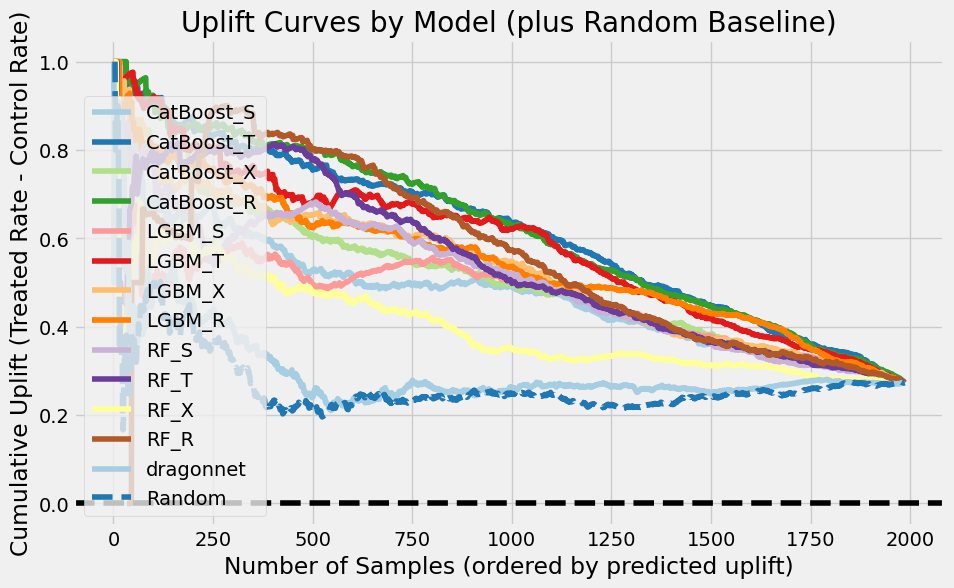

In [29]:
# Specify the model prediction columns
model_cols = [
    'CatBoost_S', 'CatBoost_T', 'CatBoost_X', 'CatBoost_R',
    'LGBM_S', 'LGBM_T', 'LGBM_X', 'LGBM_R',
    'RF_S', 'RF_T', 'RF_X', 'RF_R', 'dragonnet'
]

# Create a figure
plt.figure(figsize=(10, 6))

# For each model's predicted ITE
for col in model_cols:
    # Sort by predicted uplift (descending)
    df_sorted = df_preds.sort_values(by=col, ascending=False).reset_index(drop=True)

    # Cumulative number of treated / control
    df_sorted["cum_treated"] = (df_sorted["w"] == 1).cumsum()
    df_sorted["cum_control"] = (df_sorted["w"] == 0).cumsum()

    # Cumulative outcomes for treated / control
    df_sorted["cum_y_treated"] = (df_sorted["w"] * df_sorted["y"]).cumsum()
    df_sorted["cum_y_control"] = ((1 - df_sorted["w"]) * df_sorted["y"]).cumsum()

    # Calculate cumulative rates (handle divide-by-zero)
    df_sorted["treated_rate_cum"] = df_sorted["cum_y_treated"] / df_sorted["cum_treated"].replace(0, np.nan)
    df_sorted["control_rate_cum"] = df_sorted["cum_y_control"] / df_sorted["cum_control"].replace(0, np.nan)

    # Cumulative uplift = difference in cumulative rates
    df_sorted["uplift_cum"] = df_sorted["treated_rate_cum"] - df_sorted["control_rate_cum"]
    df_sorted["uplift_cum"] = df_sorted["uplift_cum"].fillna(method="ffill")

    # Plot the uplift curve
    plt.plot(df_sorted["uplift_cum"], label=col)

# Add a random baseline for comparison
np.random.seed(42)
df_preds["random_preds"] = np.random.rand(len(df_preds))

# Sort by the random predictions, same steps as above
df_sorted = df_preds.sort_values(by="random_preds", ascending=False).reset_index(drop=True)
df_sorted["cum_treated"] = (df_sorted["w"] == 1).cumsum()
df_sorted["cum_control"] = (df_sorted["w"] == 0).cumsum()
df_sorted["cum_y_treated"] = (df_sorted["w"] * df_sorted["y"]).cumsum()
df_sorted["cum_y_control"] = ((1 - df_sorted["w"]) * df_sorted["y"]).cumsum()
df_sorted["treated_rate_cum"] = df_sorted["cum_y_treated"] / df_sorted["cum_treated"].replace(0, np.nan)
df_sorted["control_rate_cum"] = df_sorted["cum_y_control"] / df_sorted["cum_control"].replace(0, np.nan)
df_sorted["uplift_cum"] = df_sorted["treated_rate_cum"] - df_sorted["control_rate_cum"]
df_sorted["uplift_cum"] = df_sorted["uplift_cum"].fillna(method="ffill")

# Plot the random baseline
plt.plot(df_sorted["uplift_cum"], label="Random", linestyle='--')

plt.axhline(0, color="black", linestyle="--")
plt.title("Uplift Curves by Model (plus Random Baseline)")
plt.xlabel("Number of Samples (ordered by predicted uplift)")
plt.ylabel("Cumulative Uplift (Treated Rate - Control Rate)")
plt.legend(loc="best")
plt.show()


<Figure size 1500x800 with 0 Axes>

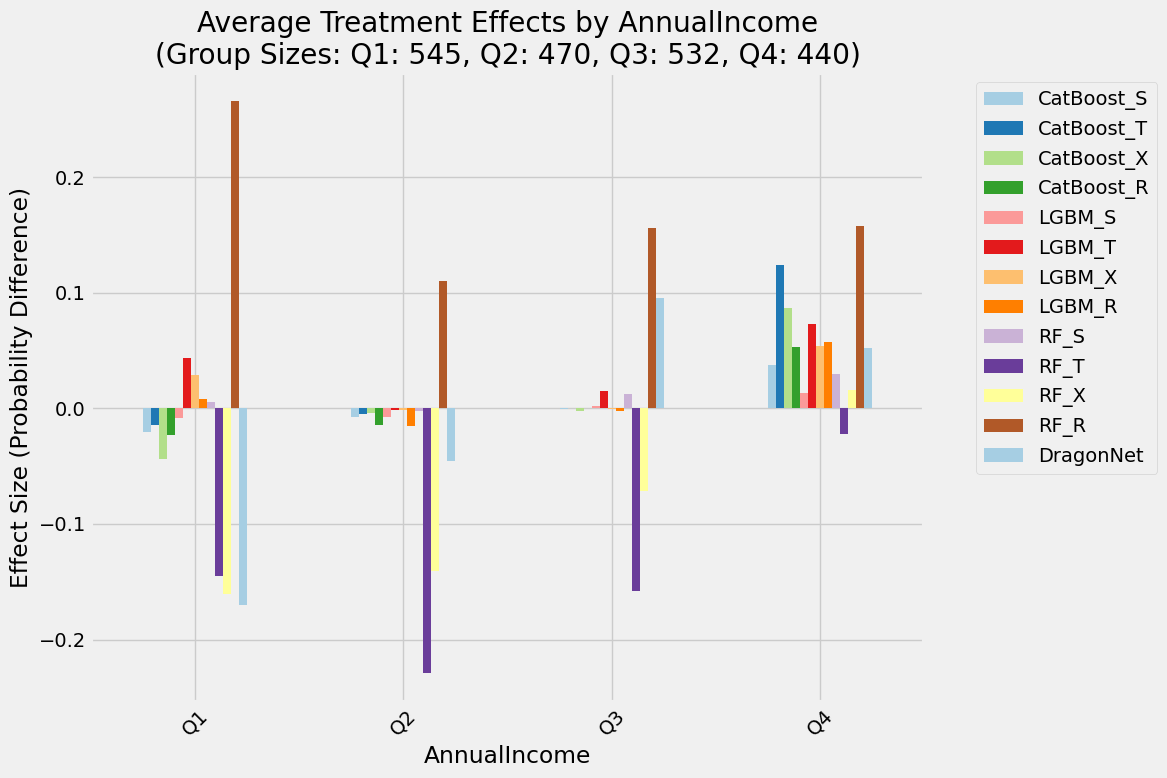


Numerical summary for AnnualIncome:
       CatBoost_S  CatBoost_T  CatBoost_X  CatBoost_R    LGBM_S    LGBM_T  \
Group                                                                       
Q1      -0.020325   -0.014281   -0.043374   -0.022657 -0.008192  0.043474   
Q2      -0.007276   -0.004983   -0.003954   -0.014448 -0.007548 -0.001682   
Q3      -0.000204    0.000697   -0.002438    0.000223  0.001957  0.015131   
Q4       0.037855    0.124306    0.087067    0.053403  0.012966  0.072846   

         LGBM_X    LGBM_R      RF_S      RF_T      RF_X      RF_R  DragonNet  
Group                                                                         
Q1     0.028604  0.007910  0.005147 -0.144760 -0.161015  0.265738  -0.170192  
Q2    -0.001262 -0.015483 -0.002601 -0.228934 -0.140472  0.110674  -0.045812  
Q3    -0.000875 -0.002290  0.012782 -0.158205 -0.071063  0.156036   0.095893  
Q4     0.054046  0.057792  0.029871 -0.022447  0.015561  0.157560   0.052303  


<Figure size 1500x800 with 0 Axes>

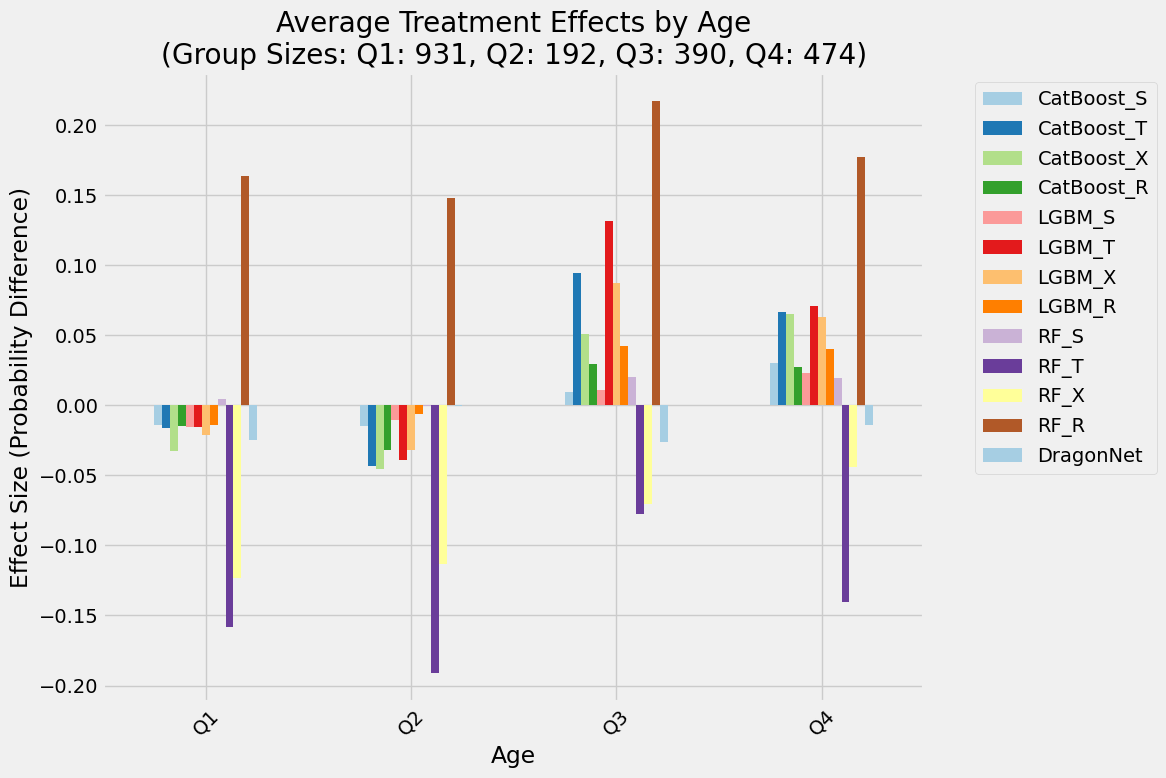


Numerical summary for Age:
       CatBoost_S  CatBoost_T  CatBoost_X  CatBoost_R    LGBM_S    LGBM_T  \
Group                                                                       
Q1      -0.013925   -0.016321   -0.032978   -0.014669 -0.015471 -0.015670   
Q2      -0.014734   -0.043160   -0.045674   -0.031851 -0.010516 -0.038809   
Q3       0.009311    0.094564    0.051154    0.029112  0.010747  0.131615   
Q4       0.029985    0.066544    0.065480    0.027205  0.023133  0.071128   

         LGBM_X    LGBM_R      RF_S      RF_T      RF_X      RF_R  DragonNet  
Group                                                                         
Q1    -0.020979 -0.013935  0.004773 -0.157881 -0.123351  0.163641  -0.024927  
Q2    -0.032065 -0.005865 -0.000238 -0.191020 -0.113496  0.147700  -0.000305  
Q3     0.087231  0.042061  0.020369 -0.077520 -0.070213  0.216939  -0.026085  
Q4     0.063245  0.039958  0.019375 -0.140588 -0.043712  0.176935  -0.014387  


<Figure size 1500x800 with 0 Axes>

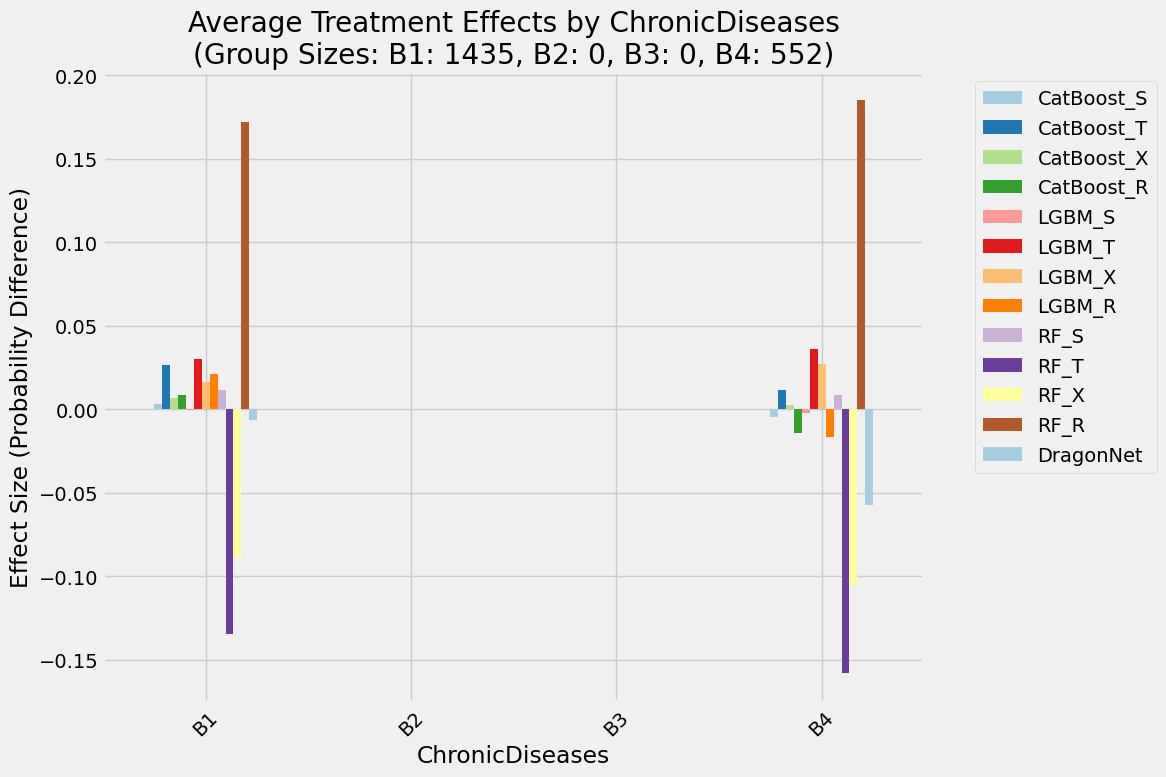


Numerical summary for ChronicDiseases:
       CatBoost_S  CatBoost_T  CatBoost_X  CatBoost_R    LGBM_S    LGBM_T  \
Group                                                                       
B1       0.003125    0.026767    0.007058    0.008638 -0.000162  0.029941   
B2            NaN         NaN         NaN         NaN       NaN       NaN   
B3            NaN         NaN         NaN         NaN       NaN       NaN   
B4      -0.004408    0.011827    0.002512   -0.014346 -0.001871  0.036303   

         LGBM_X    LGBM_R      RF_S      RF_T      RF_X      RF_R  DragonNet  
Group                                                                         
B1     0.016301  0.021145  0.011691 -0.134694 -0.088187  0.172135  -0.006141  
B2          NaN       NaN       NaN       NaN       NaN       NaN        NaN  
B3          NaN       NaN       NaN       NaN       NaN       NaN        NaN  
B4     0.027026 -0.016482  0.008604 -0.158058 -0.105410  0.185087  -0.056968  


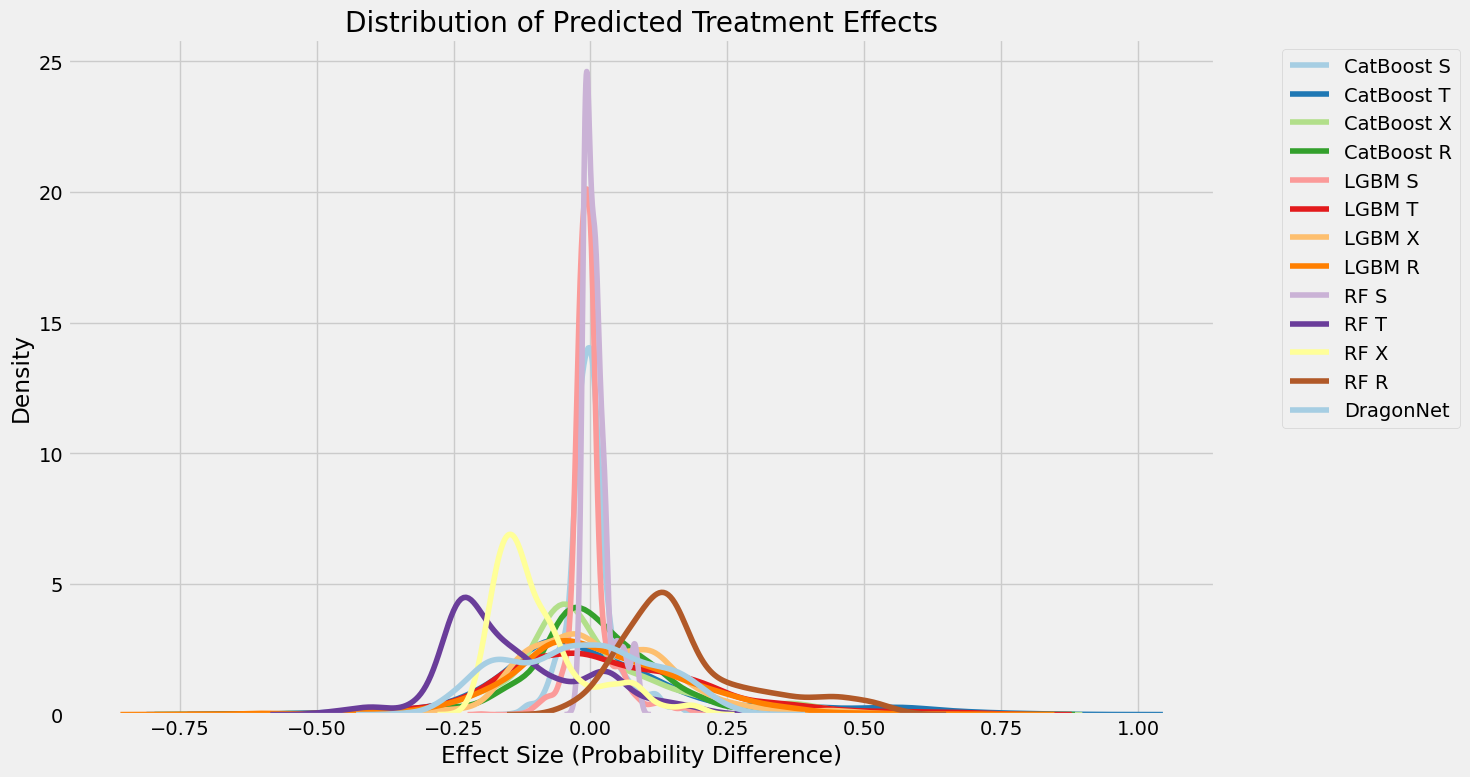

In [30]:
# List of features to analyze
features = ['AnnualIncome', 'Age', 'ChronicDiseases']
n_bins = 4

# Loop through each feature
for feature_name in features:
    if feature_name in numerical_cols:
        try:
            # Try to create quantile bins
            groups = pd.qcut(df[feature_name], q=n_bins, labels=[f'Q{i+1}' for i in range(n_bins)], duplicates='drop')
        except ValueError:
            # If that fails, use regular bins instead
            groups = pd.cut(df[feature_name], bins=n_bins, labels=[f'B{i+1}' for i in range(n_bins)])

        if groups.isna().any():
            print(f"Warning: Feature {feature_name} has too many duplicate values for meaningful binning.")
            groups = df[feature_name].map(lambda x: f"Value: {x:.2f}")
    else:
        groups = df[feature_name]

    # Create DataFrame with all effects
    effects_df = pd.DataFrame({
        'Group': groups,
        # CatBoost effects
        'CatBoost_S': s_ite.ravel(),
        'CatBoost_T': t_ite.ravel(),
        'CatBoost_X': x_ite.ravel(),
        'CatBoost_R': r_ite.ravel(),
        # LGBM effects
        'LGBM_S': lgbm_s_ite.ravel(),
        'LGBM_T': lgbm_t_ite.ravel(),
        'LGBM_X': lgbm_x_ite.ravel(),
        'LGBM_R': lgbm_r_ite.ravel(),
        # Random Forest effects
        'RF_S': rf_s_ite.ravel(),
        'RF_T': rf_t_ite.ravel(),
        'RF_X': rf_x_ite.ravel(),
        'RF_R': rf_r_ite.ravel(),
        # DragonNet effects
        'DragonNet': dragon_ite.ravel()
    })

    # Calculate mean effects by group
    mean_effects = effects_df.groupby('Group')[[
        'CatBoost_S', 'CatBoost_T', 'CatBoost_X', 'CatBoost_R',
        'LGBM_S', 'LGBM_T', 'LGBM_X', 'LGBM_R',
        'RF_S', 'RF_T', 'RF_X', 'RF_R', 'DragonNet'
    ]].mean()

    # Get group counts
    group_counts = effects_df.groupby('Group').size()

    # Create plot
    plt.figure(figsize=(15, 8))
    mean_effects.plot(kind='bar')
    plt.title(f'Average Treatment Effects by {feature_name}\n(Group Sizes: ' +
              ', '.join([f"{k}: {v}" for k, v in group_counts.items()]) + ')')
    plt.xlabel(feature_name)
    plt.ylabel('Effect Size (Probability Difference)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print numerical summary
    print(f"\nNumerical summary for {feature_name}:")
    print(mean_effects)

# Plot probability distributions for all models
plt.figure(figsize=(15, 8))

# Plot CatBoost distributions
for name, ite in zip(['CatBoost S', 'CatBoost T', 'CatBoost X', 'CatBoost R'],
                    [s_ite, t_ite, x_ite, r_ite]):
    sns.kdeplot(ite.ravel(), label=name)

# Plot LGBM distributions
for name, ite in zip(['LGBM S', 'LGBM T', 'LGBM X', 'LGBM R'],
                    [lgbm_s_ite, lgbm_t_ite, lgbm_x_ite, lgbm_r_ite]):
    sns.kdeplot(ite.ravel(), label=name)

# Plot Random Forest distributions
for name, ite in zip(['RF S', 'RF T', 'RF X', 'RF R'],
                    [rf_s_ite, rf_t_ite, rf_x_ite, rf_r_ite]):
    sns.kdeplot(ite.ravel(), label=name)

# Plot DragonNet distribution
sns.kdeplot(dragon_ite.ravel(), label='DragonNet')

plt.title('Distribution of Predicted Treatment Effects')
plt.xlabel('Effect Size (Probability Difference)')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

####Uplift Curves
The uplift curves provide insights into the effectiveness of the Frequent Flyer program across different customer segments. Most models outperform random chance, indicating a meaningful impact. Interestingly, many models demonstrate strong performance initially, but their effectiveness declines as more customers are included. This suggests that the program's impact may be particularly strong for specific customer segments. While the results support the value of Frequent Flyer strategies, they also highlight the need for segment-specific approaches to maximize effectiveness.

####Annual Income
When segmenting the effects by income brackets, there is a strong positive impact observed in the highest quartile, with most models agreeing on this trend. However, Random Forest with the T-Learner consistently shows a negative effect, which may indicate modeling inconsistencies or underlying data characteristics that affect how this model fits the treatment effect.

####Age
The analysis by age group reveals that the strongest effects are concentrated in Q3 and Q4 (older age segments), suggesting that older customers may have a greater interest in health-related topics and, consequently, a higher likelihood of purchasing insurance. In contrast, younger customers may perceive insurance benefits differently, leading to a weaker or less consistent effect.

####Chronic Diseases
Insights for this group are somewhat limited due to data imbalance. However, across both chronic disease statuses, the models show a consistent effect on insurance uptake, though the impact is not particularly strong. Surprisingly, this suggests that chronic disease status may not be a significant factor in influencing insurance purchases.

####Distribution of Effect Analysis
Most models converge around a slightly positive effect, reinforcing the overall positive impact of the Frequent Flyer program. This distribution pattern suggests that while the program's influence remains consistent, the magnitude of its impact varies significantly across different customer segments and modeling approaches. These findings emphasize the importance of targeted strategies to optimize the program’s effectiveness.


While the FrequentFlyer program shows clear positive impact on insurance purchases, its effectiveness varies significantly across customer segments. The key to maximizing program ROI lies in targeted marketing, segment-specific value propositions, and sophisticated customer modeling approaches. The business should focus on high-yield segments while developing strategies to improve effectiveness in segments currently showing lower response rates.
